# Proyek Klasifikasi Gambar: Prediksi Tumor Otak
- **Nama:** Annisa Saninah
- **Email:** saninahannisa@gmail.com
- **ID Dicoding:** annisa1212

## Import Semua Packages/Library yang Digunakan

In [1]:
from PIL import Image
import os
import numpy as np
import tensorflow as tf
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Conv2D, MaxPooling2D, Flatten, Dropout
import cv2
import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning)
import matplotlib.pyplot as plt
import io
from google.colab import files

## Data Preparation

### Data Loading

In [2]:
def load_images(directory):
    images = []
    for filename in os.listdir(directory):

          img = Image.open(os.path.join(directory, filename))
          img = img.resize((224, 224))
          img = img.convert('RGB')
          img = np.array(img) / 255.0
          images.append(img)
    return images

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [12]:
train_dir = '/content/drive/MyDrive/datasets/Training'
test_dir = '/content/drive/MyDrive/datasets/Testing'

### Data Preprocessing

In [11]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.model_selection import train_test_split

Found 4274 images belonging to 4 classes.
Found 1066 images belonging to 4 classes.
Found 0 images belonging to 4 classes.


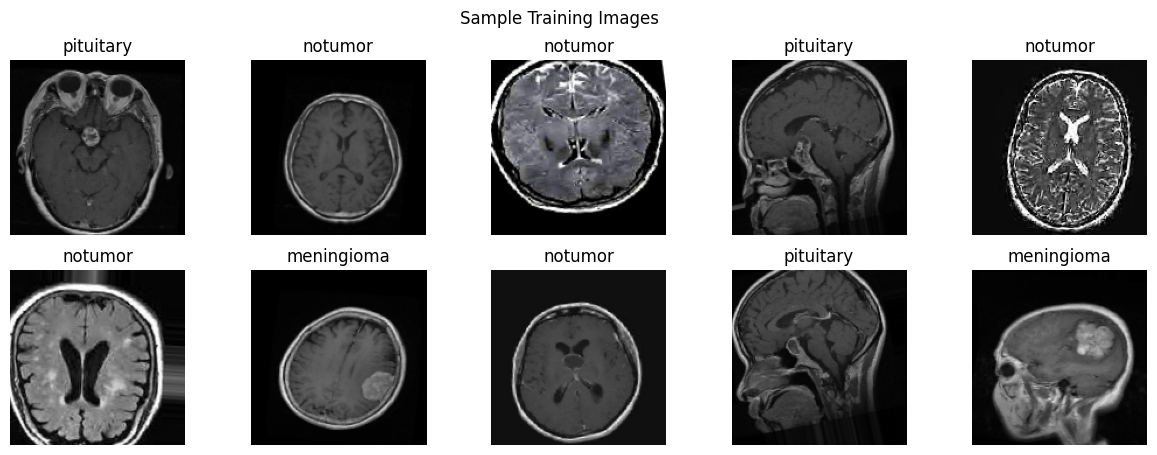

In [13]:
# Setup ImageDataGenerator untuk normalisasi dan augmentasi
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=15,
    width_shift_range=0.1,
    height_shift_range=0.1,
    zoom_range=0.1,
    horizontal_flip=True,
    validation_split=0.2  # 20% dari data training untuk validasi
)

test_datagen = ImageDataGenerator(rescale=1./255)

# Membuat generator data untuk training
train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(150, 150),
    batch_size=32,
    class_mode='categorical',
    subset='training',
    shuffle=True,
    seed=42
)

# Membuat generator data untuk validasi
val_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(150, 150),
    batch_size=32,
    class_mode='categorical',
    subset='validation',
    shuffle=True,
    seed=42
)

# Membuat generator data untuk pengujian
test_generator = test_datagen.flow_from_directory(
    test_dir,
    target_size=(150, 150),
    batch_size=32,
    class_mode='categorical',
    shuffle=False
)

# Menampilkan beberapa sampel gambar
def show_sample_images(generator, title):
    class_names = list(generator.class_indices.keys())
    images, labels = next(generator)
    plt.figure(figsize=(15, 5))
    for i in range(10):
        plt.subplot(2, 5, i + 1)
        plt.imshow(images[i])
        plt.title(class_names[np.argmax(labels[i])])
        plt.axis('off')
    plt.suptitle(title)
    plt.show()

show_sample_images(train_generator, "Sample Training Images")

Class mapping: {'glioma': 0, 'meningioma': 1, 'notumor': 2, 'pituitary': 3}


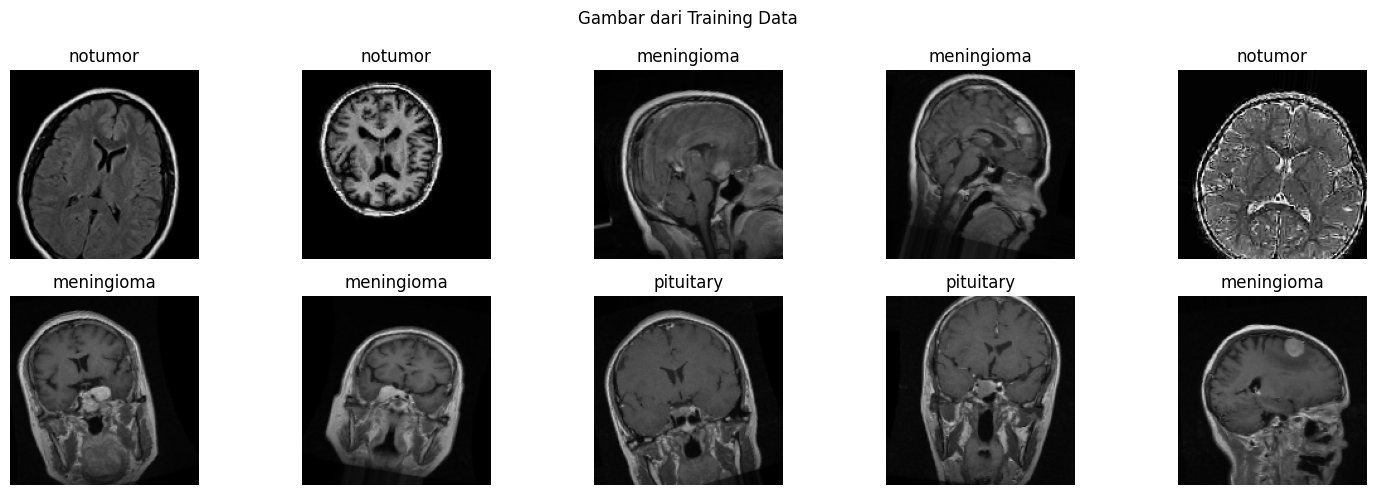

In [14]:
class_names = list(train_generator.class_indices.keys())
print("Class mapping:", train_generator.class_indices)

def show_sample_images(generator, title):
    images, labels = next(generator)
    plt.figure(figsize=(15, 5))
    for i in range(10):
        plt.subplot(2, 5, i + 1)
        plt.imshow(images[i])
        plt.title(class_names[np.argmax(labels[i])])
        plt.axis('off')
    plt.suptitle(title)
    plt.tight_layout()
    plt.show()

show_sample_images(train_generator, "Gambar dari Training Data")

In [16]:
def load_images_and_labels(directory):
    data = []
    labels = []
    class_names = sorted(os.listdir(directory))  # ['glioma', 'meningioma', 'notumor', 'pituitary']

    for label in class_names:
        folder_path = os.path.join(directory, label)
        if not os.path.isdir(folder_path):
            continue

        for filename in tqdm(os.listdir(folder_path), desc=f"Loading {label}"):
            file_path = os.path.join(folder_path, filename)
            img = cv2.imread(file_path)
            if img is not None:
                img = cv2.resize(img, (IMG_SIZE, IMG_SIZE))
                data.append(img)
                labels.append(label)

    return np.array(data), np.array(labels), class_names

In [22]:
from tqdm import tqdm
import os
import cv2
import numpy as np

IMG_SIZE = 150

def load_images_and_labels(directory):
    data = []
    labels = []
    class_names = sorted(os.listdir(directory))  # ['glioma', 'meningioma', 'notumor', 'pituitary']

    for label in class_names:
        folder_path = os.path.join(directory, label)
        if not os.path.isdir(folder_path):
            continue

        for filename in tqdm(os.listdir(folder_path), desc=f"Loading {label}"):
            file_path = os.path.join(folder_path, filename)
            img = cv2.imread(file_path)
            if img is not None:
                img = cv2.resize(img, (IMG_SIZE, IMG_SIZE))
                data.append(img)
                labels.append(label)

    return np.array(data), np.array(labels), class_names

#### Split Dataset

In [24]:
X_train, y_train_raw, class_names = load_images_and_labels(train_dir)
X_test, y_test_raw, _ = load_images_and_labels(test_dir)
print("Class Names:", class_names)
print("label mentah:", y_train_raw[:5])

Loading pituitary: 100%|██████████| 1457/1457 [00:44<00:00, 32.62it/s]
Loading glioma: 0it [00:00, ?it/s]
Loading meningioma: 0it [00:00, ?it/s]
Loading notumor: 0it [00:00, ?it/s]
Loading pituitary: 0it [00:00, ?it/s]

Class Names: ['glioma', 'meningioma', 'notumor', 'pituitary']
label mentah: ['glioma' 'glioma' 'glioma' 'glioma' 'glioma']


In [25]:
# Label encoding (text → angka)
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()
y_train = le.fit_transform(y_train_raw)
y_test = le.transform(y_test_raw)

print("label encoded:", y_train[:5])
print("Mapping Label:", dict(zip(le.classes_, le.transform(le.classes_))))

label encoded: [0 0 0 0 0]
Mapping Label: {np.str_('glioma'): np.int64(0), np.str_('meningioma'): np.int64(1), np.str_('notumor'): np.int64(2), np.str_('pituitary'): np.int64(3)}


In [26]:
X_train = X_train / 255.0
X_test = X_test / 255.0

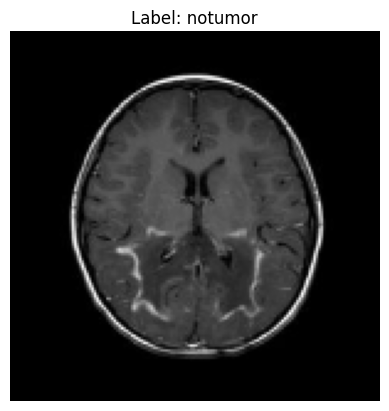

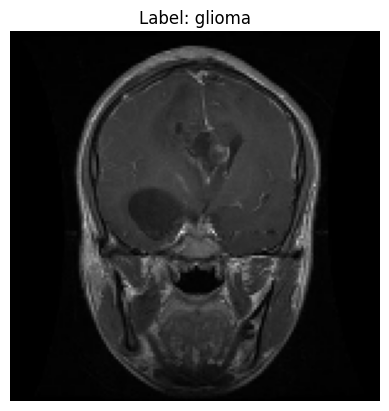

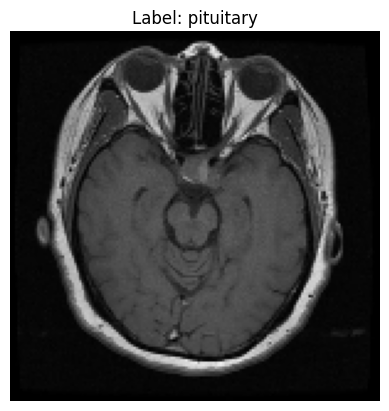

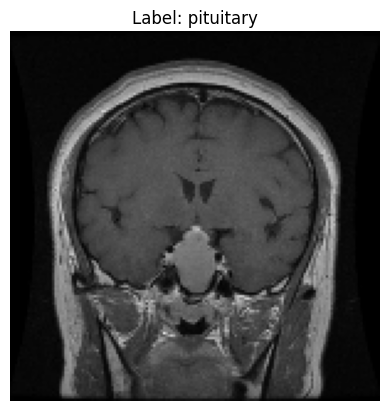

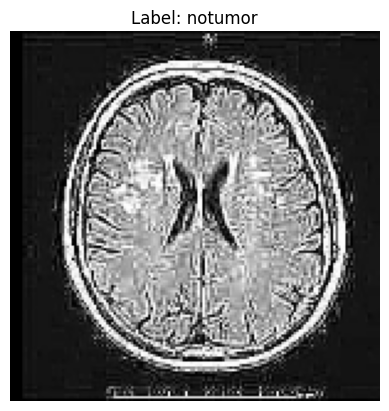

In [33]:
import tensorflow as tf
import matplotlib.pyplot as plt

# Konversi ke tf.data.Dataset
train_dataset = tf.data.Dataset.from_tensor_slices((X_train, y_train))
test_dataset = tf.data.Dataset.from_tensor_slices((X_test, y_test))

# Ambil contoh 5 gambar dari training set
for image, label in train_dataset.take(5):
    plt.figure()
    plt.imshow(image.numpy().astype("uint8"))
    plt.title('Label: {}'.format(class_names[label.numpy()]))
    plt.axis('off')
    plt.show()

In [34]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras.utils import to_categorical

# Konversi label jadi one-hot
y_train_cat = to_categorical(y_train, num_classes=4)
y_test_cat = to_categorical(y_test, num_classes=4)

# Konversi ke tf.data.Dataset
train_ds = tf.data.Dataset.from_tensor_slices((X_train, y_train_cat))
val_ds   = tf.data.Dataset.from_tensor_slices((X_test, y_test_cat))

# Split sebagian test jadi validasi (opsional)
val_size = int(0.1 * len(X_test))
val_ds = val_ds.take(val_size)
test_ds = val_ds.skip(val_size)

# Atur batch & shuffle
BATCH_SIZE = 32
train_ds = train_ds.shuffle(buffer_size=1000).batch(BATCH_SIZE)
val_ds = val_ds.batch(BATCH_SIZE)
test_ds = test_ds.batch(BATCH_SIZE)

Modelling

In [35]:
model = Sequential()

# Conv Layer 1
model.add(Conv2D(32, (3,3), activation='relu', input_shape=(150, 150, 3)))
model.add(MaxPooling2D(pool_size=(2,2)))

# Conv Layer 2
model.add(Conv2D(64, (3,3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2,2)))

# Conv Layer 3
model.add(Conv2D(128, (3,3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2,2)))

# FC Layers
model.add(Flatten())
model.add(Dense(256, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(4, activation='softmax'))  # 4 kelas

# Model Summary
model.summary()

/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 148, 148, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 74, 74, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 72, 72, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 36, 36, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 34, 34, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 17, 17, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 36992)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 256)            │     9,470,208 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 4)              │         1,028 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 9,564,484 (36.49 MB)

 Trainable params: 9,564,484 (36.49 MB)

 Non-trainable params: 0 (0.00 B)

In [36]:
model.compile(
    optimizer='adam',
    loss='categorical_crossentropy',  # multiclass
    metrics=['accuracy']
)

In [37]:
# Train
history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=20,
    verbose=1
)

Epoch 1/20
134/134 ━━━━━━━━━━━━━━━━━━━━ 217s 2s/step - accuracy: 0.5759 - loss: 37.7746 - val_accuracy: 0.8679 - val_loss: 0.5153
Epoch 2/20
134/134 ━━━━━━━━━━━━━━━━━━━━ 258s 2s/step - accuracy: 0.8705 - loss: 0.4077 - val_accuracy: 0.9057 - val_loss: 0.4177
Epoch 3/20
134/134 ━━━━━━━━━━━━━━━━━━━━ 211s 2s/step - accuracy: 0.9119 - loss: 0.2710 - val_accuracy: 0.8962 - val_loss: 0.4257
Epoch 4/20
134/134 ━━━━━━━━━━━━━━━━━━━━ 261s 2s/step - accuracy: 0.9345 - loss: 0.1965 - val_accuracy: 0.9151 - val_loss: 0.4340
Epoch 5/20
134/134 ━━━━━━━━━━━━━━━━━━━━ 206s 2s/step - accuracy: 0.9374 - loss: 0.1861 - val_accuracy: 0.9340 - val_loss: 0.3803
Epoch 6/20
134/134 ━━━━━━━━━━━━━━━━━━━━ 205s 2s/step - accuracy: 0.9515 - loss: 0.1537 - val_accuracy: 0.9434 - val_loss: 0.4385
Epoch 7/20
134/134 ━━━━━━━━━━━━━━━━━━━━ 205s 2s/step - accuracy: 0.9632 - loss: 0.1209 - val_accuracy: 0.9057 - val_loss: 0.4233
Epoch 8/20
134/134 ━━━━━━━━━━━━━━━━━━━━ 266s 2s/step - accuracy: 0.9755 - loss: 0.0703 - val_acc

## Evaluasi dan Visualisasi

In [39]:
# Buat ulang test_ds sebelum evaluate
test_ds = tf.data.Dataset.from_tensor_slices((X_test, y_test_cat))
test_ds = test_ds.batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)

# Evaluasi
test_loss, test_acc = model.evaluate(test_ds)
print("Akurasi di data testing: {:.2f}%".format(test_acc * 100))

34/34 ━━━━━━━━━━━━━━━━━━━━ 15s 448ms/step - accuracy: 0.9437 - loss: 0.3853
Akurasi di data testing: 94.10%


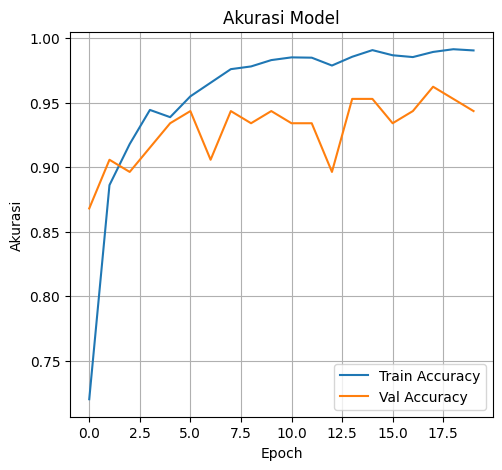

In [40]:
# Plot akurasi
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Val Accuracy')
plt.title('Akurasi Model')
plt.xlabel('Epoch')
plt.ylabel('Akurasi')
plt.legend()
plt.grid(True)

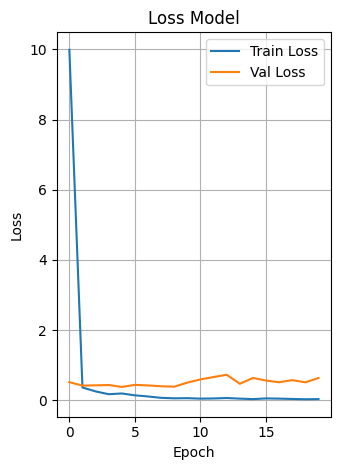

In [41]:
# Plot loss
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.title('Loss Model')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()

Konversi Model

In [43]:
model.export('saved_model/brain_tumor_model')

Saved artifact at 'saved_model/brain_tumor_model'. The following endpoints are available:

* Endpoint 'serve'
  args_0 (POSITIONAL_ONLY): TensorSpec(shape=(None, 150, 150, 3), dtype=tf.float32, name='keras_tensor')
Output Type:
  TensorSpec(shape=(None, 4), dtype=tf.float32, name=None)
Captures:
  136630898412816: TensorSpec(shape=(), dtype=tf.resource, name=None)
  136630898413584: TensorSpec(shape=(), dtype=tf.resource, name=None)
  136630898411088: TensorSpec(shape=(), dtype=tf.resource, name=None)
  136630898410704: TensorSpec(shape=(), dtype=tf.resource, name=None)
  136630898415120: TensorSpec(shape=(), dtype=tf.resource, name=None)
  136630898415888: TensorSpec(shape=(), dtype=tf.resource, name=None)
  136630898417040: TensorSpec(shape=(), dtype=tf.resource, name=None)
  136630898417232: TensorSpec(shape=(), dtype=tf.resource, name=None)
  136630898415312: TensorSpec(shape=(), dtype=tf.resource, name=None)
  136630898418960: TensorSpec(shape=(), dtype=tf.resource, name=None)


In [44]:
model.save('brain_tumor_model.keras')

In [45]:
model.save('brain_tumor_model.h5')

In [64]:
converter = tf.lite.TFLiteConverter.from_saved_model('saved_model/brain_tumor_model')

In [65]:
# Konversi model ke TFLite
converter = tf.lite.TFLiteConverter.from_keras_model(model)
tflite_model = converter.convert()

# Simpan model TFLite
with open('brain_tumor_classification.tflite', 'wb') as f:
    f.write(tflite_model)

print("Model berhasil dikonversi ke TFLite")

Saved artifact at '/tmp/tmpd_vw_j1g'. The following endpoints are available:

* Endpoint 'serve'
  args_0 (POSITIONAL_ONLY): TensorSpec(shape=(None, 150, 150, 3), dtype=tf.float32, name='keras_tensor')
Output Type:
  TensorSpec(shape=(None, 4), dtype=tf.float32, name=None)
Captures:
  136630898412816: TensorSpec(shape=(), dtype=tf.resource, name=None)
  136630898413584: TensorSpec(shape=(), dtype=tf.resource, name=None)
  136630898411088: TensorSpec(shape=(), dtype=tf.resource, name=None)
  136630898410704: TensorSpec(shape=(), dtype=tf.resource, name=None)
  136630898415120: TensorSpec(shape=(), dtype=tf.resource, name=None)
  136630898415888: TensorSpec(shape=(), dtype=tf.resource, name=None)
  136630898417040: TensorSpec(shape=(), dtype=tf.resource, name=None)
  136630898417232: TensorSpec(shape=(), dtype=tf.resource, name=None)
  136630898415312: TensorSpec(shape=(), dtype=tf.resource, name=None)
  136630898418960: TensorSpec(shape=(), dtype=tf.resource, name=None)
Model berhasil d

In [66]:
with open('brain_tumor_model_labels.txt', 'w') as f:
    for label in class_names:
        f.write(f"{label}\n")

In [67]:
pip install tensorflowjs

In [68]:
# Konversi dan simpan model dalam format TFJS (untuk browser/JavaScript)
# tensorflowjs sudah terinstall
try:
    import tensorflowjs as tfjs
    tfjs_model_path = './tfjs_model'
    tfjs.converters.save_keras_model(model, tfjs_model_path)
    print(f"Model berhasil dikonversi ke TFJS dan disimpan di: {tfjs_model_path}")
except ImportError:
    print("Package tensorflowjs tidak ditemukan. Instal dengan: pip install tensorflowjs")

failed to lookup keras version from the file,
    this is likely a weight only file
Model berhasil dikonversi ke TFJS dan disimpan di: ./tfjs_model


## Inference (Optional)